# Exploratory Data Analysis Notebook

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import src.tools
import datetime
import src.pre_process as pp
import nest_asyncio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', None)

In [48]:
#%% Ingest and or Process
today = '_'.join(str(datetime.datetime.today()).split(' ')[0].split('-'))
try:
    df = pd.read_pickle(".data/" + today + "_df")
    gw_df = pd.read_pickle(".data/" + today + "_gw_df")
except FileNotFoundError:
    nest_asyncio.apply()
    print('Downloading')
    df, gw_df = pp.main(save_to_file=True)

In [49]:
player_categories = ["Goalkeeper", "Defender", "Midfielder", "Forward"]
position_colors_list = ["red", "blue", "Orange", "Green"]
position_colors = {cat: color for cat, color in zip(player_categories, position_colors_list)}

In [50]:
df.sample(5)

,dreamteam_count,element_type,event_points,form,in_dreamteam,now_cost,points_per_game,selected_by_percent,team,total_points,transfers_in,transfers_out,value_form,value_season,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,creativity_rank,threat_rank,ict_index_rank,player_name,games,xG,xA,shots,key_passes,npg,npxG,xGChain,xGBuildup
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
591,0,Forward,0,0.2,False,60,1.7,0.2,8,24,71096,64450,0.0,4.0,710,1,0,2,15,0,0,0,2,0,0,2,63,77.0,94.9,301.0,47.2,369,243,104,252,Salomón Rondón,14,2.412409179843962,0.5214151497930288,18,7,1,2.412409179843962,3.341835469007492,0.4856187906116247
152,0,Midfielder,1,0.0,False,53,1.2,0.0,7,15,3415,10112,0.0,2.8,647,0,0,1,13,1,0,0,1,0,0,0,98,70.2,145.2,38.0,25.3,378,188,342,340,Luka Milivojevic,12,0.2893703170120716,0.5382447391748428,8,7,0,0.2893703170120716,2.7315842732787132,2.410440620034933
317,0,Midfielder,0,0.2,False,44,1.4,0.2,15,15,48010,46960,0.0,3.4,490,0,0,0,10,0,0,0,0,0,0,0,84,67.0,111.5,108.0,28.6,383,226,246,323,Lukas Rupp,11,0.42850622814148664,1.2350856140255928,11,8,0,0.42850622814148664,2.236474161967635,1.3101458717137575
270,2,Goalkeeper,2,3.7,False,52,4.0,11.7,13,112,1828176,1219343,0.7,21.5,2520,0,0,7,38,0,2,0,0,0,103,7,530,795.6,0.3,0.0,79.2,2,472,689,143,David de Gea,28,0,0,0,0,0,0,2.726584111340344,2.726584111340344
122,3,Defender,0,1.3,False,56,4.1,8.4,6,78,3140122,2959975,0.2,13.9,1445,1,4,6,14,0,0,0,6,0,0,9,333,325.6,390.3,283.0,100.1,150,56,114,80,Marcos Alonso,19,1.6831710208207369,2.961708150804043,25,25,1,1.6831710208207369,7.900173470377922,5.878161035478115


In [51]:
len(df)

344

In [52]:
df.groupby(['element_type'])['form'].count()

def generate_pie(df,names, values):
    df_plot = df.groupby([names])[values].count().reset_index()
    print('hello')
    px.pie(df_plot, names=names, values=values, hole=.3)

generate_pie(df, 'element_type', 'form')

hello


In [53]:
generate_pie(df, 'element_type', 'form')

hello


In [54]:
px.pie(df.groupby(['element_type'])['player_name'].count().reset_index(),
                  names='element_type',
                  values='player_name',
                  color='element_type',
                  hole=.3,
                  color_discrete_map=position_colors
                  )

In [55]:
#Mean total points
px.pie(df.groupby(['element_type'])['total_points'].mean().reset_index(),
                  names='element_type',
                  values='total_points',
                  color='element_type',
                  hole=.3,
                  color_discrete_map=position_colors
                  )

In [56]:
with open('.data/history.json', 'r') as f:
  hist_data = json.load(f)
  # ensuring player id is an integer
hist_data = {int(key):value for key,value in hist_data.items()}

FileNotFoundError: [Errno 2] No such file or directory: '.data/history.json'

In [16]:
try:
    detailed_df = pd.read_pickle(today2)
except FileNotFoundError:
    detailed_df = pd.DataFrame()

    for id in df.index:
        history = pd.DataFrame(hist_data[id]['history'])

        # Goals for and against
        history['goals_for'] = history['team_h_score'].where(history['was_home'], history['team_a_score'])
        history['goals_against'] = history['team_a_score'].where(history['was_home'], history['team_h_score'])

        # Drop irrelevant columns
        history = history.drop(columns=['team_h_score','team_a_score','element','fixture','kickoff_time','opponent_team'])

        # groupBY sum gameweeks
        mean_cols =['value', 'transfers_balance', 'selected', 'transfers_in','transfers_out']
        history = pd.concat([history.groupby('round').sum().drop(columns=mean_cols), history.groupby('round')[mean_cols].mean()], axis=1)

        # Finding empty gameweeks
        for empty_gw in np.arange(1,max(history.index)):
            if empty_gw not in history.index:
                history.loc[empty_gw] = None
        history = history.sort_index()

        # filling interpolated transfer data or zeros for gw data
        history[['value', 'transfers_balance', 'selected','transfers_in', 'transfers_out']] = \
            history[['value', 'transfers_balance', 'selected', 'transfers_in', 'transfers_out']].interpolate(method='linear')
        history = history.fillna(0)

        # Adding a cumulative sum of points
        history['points_cumsum'] = history['total_points'].cumsum()

        # Adding player ID to df
        history['id'] = id

        # Adding general player data 
        player_df = pd.merge(history, df[['team', 'element_type', 'player_name']], left_on='id', right_index=True,)

        detailed_df = pd.concat([detailed_df, player_df], axis=0)

    detailed_df = detailed_df.reset_index()
    detailed_df.to_pickle(today2)

In [17]:
detailed_df

,round,total_points,was_home,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,goals_for,goals_against,value,transfers_balance,selected,transfers_in,transfers_out,points_cumsum,id,team,element_type,player_name
0,1,1.0,0.0,90.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,2.0,50.0,0.0,153122.0,0.0,0.0,1.0,1,1,1,Bernd Leno
1,2,2.0,1.0,90.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,17.0,0.0,2.0,50.0,-25816.0,144885.0,2627.0,28443.0,3.0,1,1,1,Bernd Leno
2,3,1.0,0.0,90.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,20.0,0.0,5.0,49.0,-14559.0,136757.0,5164.0,19723.0,4.0,1,1,1,Bernd Leno
3,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.0,6564.0,153130.0,35360.0,28796.0,4.0,1,1,1,Bernd Leno
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.0,-23847.0,129851.0,4822.0,28669.0,4.0,1,1,1,Bernd Leno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11811,24,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45.0,30.0,321.0,105.0,75.0,3.0,685,20,2,Toti António Gomes
11812,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,45.0,2.0,357.0,31.0,29.0,3.0,685,20,2,Toti António Gomes
11813,26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,45.0,-18.0,400.0,36.0,54.0,3.0,685,20,2,Toti António Gomes
11814,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45.0,-12.0,462.0,38.0,50.0,3.0,685,20,2,Toti António Gomes


In [18]:
value_df = detailed_df.groupby(['player_name','round'])[['value']].max()
value_df #= value_df[value_df['value'] >]

value
player_name     round       
Aaron Cresswell 1       55.0
                2       55.0
                3       55.0
                4       55.0
                5       55.0
...                      ...
Çaglar Söyüncü  24      49.0
                25      49.0
                26      49.0
                27      49.0
                28      49.0

[11732 rows x 1 columns]

In [19]:
player_categories = [1, 2, 3, 4]
position_colors_list = ["red", "blue", "Orange", "Green"]
position_colors = {cat: color for cat, color in zip(player_categories, position_colors_list)}

In [57]:
# px.pie(df.groupby(['element_type'])['player_name'].count().reset_index(),
#                   names='element_type',
#                   values='player_name',
#                   color='element_type',
#                   hole=.3,
#                   color_discrete_map=position_colors
#                   )

px.scatter(df, 
           x='now_cost', y='total_points',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='Total points vs Current Price'
              )

# sns.scatterplot(x = df['now_cost'], y = df['total_points'], hue=df['element_type'], palette=position_colors)

In [94]:
df['points_per_game'] = pd.to_numeric(df['points_per_game'])
df['xA'] = pd.to_numeric(df['xA'])
df['xG'] = pd.to_numeric(df['xG'])
df['shots'] = pd.to_numeric(df['shots'])
df['key_passes'] = pd.to_numeric(df['key_passes'])
df['selected_by_percent'] = pd.to_numeric(df['selected_by_percent'])
df['form'] = pd.to_numeric(df['form'])

px.scatter(df, 
           x='now_cost', y='points_per_game',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name', 'games'],
           title='Points per Game vs Current Price'
              )


#sns.scatterplot(x = df['now_cost'], y = df['points_per_game'], hue=df['element_type'], palette=position_colors)

In [95]:
px.scatter(df, 
           x='xG', y='goals_scored',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='Goals scored vs xG'
              )

#sns.scatterplot(x = df['xG'], y = df['goals_scored'], hue=df['element_type'], palette=position_colors)

In [97]:
px.scatter(df, 
           x='xA', y='assists',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='Assists provided vs xA'
              )

#sns.scatterplot(x = df['xA'], y = df['assists'], hue=df['element_type'], palette=position_colors)

In [98]:
px.scatter(df, 
           x='xA', y='xG',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='xG vs xA'
              )

#sns.scatterplot(x = df['xA'], y = df['xG'], hue=df['element_type'], palette=position_colors)

In [99]:
px.scatter(df, 
           x='now_cost', y='dreamteam_count',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='Dreamteam count vs Cost'
              )

#sns.scatterplot(x = df['now_cost'], y = df['dreamteam_count'], hue=df['element_type'], palette=position_colors)

In [102]:
px.scatter(df, 
           x='selected_by_percent', y='total_points',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='Total Points vs Selected By Percent'
              )

#'selected_by_percent'sns.scatterplot(x = df['selected_by_percent'], y = df['total_points'], hue=df['element_type'], palette=position_colors)

In [103]:
px.scatter(df, 
           x='selected_by_percent', y='form',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='Total Points vs Selected By Percent'
              )


#sns.scatterplot(x = df['selected_by_percent'], y = df['form'], hue=df['element_type'], palette=position_colors)

<AxesSubplot:xlabel='total_points', ylabel='form'>

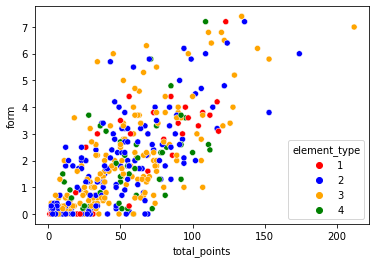

In [47]:
px.scatter(df, 
           x='selected_by_percent', y='form',
           color='element_type',
           color_discrete_map=position_colors,
           hover_data= ['player_name'],
           title='Total Points vs Selected By Percent'
              )


sns.scatterplot(x = df['total_points'], y = df['form'], hue=df['element_type'], palette=position_colors)

In [44]:
df.columns

Index(['dreamteam_count', 'element_type', 'event_points', 'form',
       'in_dreamteam', 'now_cost', 'points_per_game', 'selected_by_percent',
       'team', 'total_points', 'transfers_in', 'transfers_out', 'value_form',
       'value_season', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'influence_rank',
       'creativity_rank', 'threat_rank', 'ict_index_rank', 'player_name',
       'games', 'xG', 'xA', 'shots', 'key_passes', 'npg', 'npxG', 'xGChain',
       'xGBuildup'],
      dtype='object')

In [46]:
columns = ['dreamteam_count', 'form', 'now_cost', 'points_per_game', 'selected_by_percent',
       'total_points', 'transfers_in', 'transfers_out', 'value_form',
       'value_season', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'games', 'xG', 'xA', 'shots', 
       'key_passes', 'npg', 'npxG', 'xGChain', 'xGBuildup']

In [47]:
[{"label":value, "value":value} for value in columns]


[{'label': 'dreamteam_count', 'value': 'dreamteam_count'},
 {'label': 'form', 'value': 'form'},
 {'label': 'now_cost', 'value': 'now_cost'},
 {'label': 'points_per_game', 'value': 'points_per_game'},
 {'label': 'selected_by_percent', 'value': 'selected_by_percent'},
 {'label': 'total_points', 'value': 'total_points'},
 {'label': 'transfers_in', 'value': 'transfers_in'},
 {'label': 'transfers_out', 'value': 'transfers_out'},
 {'label': 'value_form', 'value': 'value_form'},
 {'label': 'value_season', 'value': 'value_season'},
 {'label': 'minutes', 'value': 'minutes'},
 {'label': 'goals_scored', 'value': 'goals_scored'},
 {'label': 'assists', 'value': 'assists'},
 {'label': 'clean_sheets', 'value': 'clean_sheets'},
 {'label': 'goals_conceded', 'value': 'goals_conceded'},
 {'label': 'own_goals', 'value': 'own_goals'},
 {'label': 'penalties_saved', 'value': 'penalties_saved'},
 {'label': 'penalties_missed', 'value': 'penalties_missed'},
 {'label': 'yellow_cards', 'value': 'yellow_cards'},
 

In [49]:
data_points = []

for id in df.index:
    history = pd.DataFrame(hist_data[id]['history'])

    # Create team columns
    team_cols = {i:'opponent_team_is_'+str(i) for i in np.arange(1,21)}
    history[list(team_cols.values())] = 0
    opponent_dummies = pd.get_dummies(history['opponent_team']).rename(columns=team_cols)
    history[list(opponent_dummies.columns)] = opponent_dummies

    # Get fixture difficulty
    history = pd.concat([history,get_difficulty(team_df=team_df, history=history)], axis=1)

    # Goals for and against
    history['goals_for'] = history['team_h_score'].where(history['was_home'], history['team_a_score'])
    history['goals_against'] = history['team_a_score'].where(history['was_home'], history['team_h_score'])

    # Drop irrelevant columns
    history = history.drop(columns=['team_h_score','team_a_score','element','fixture','kickoff_time','opponent_team'])

    # groupBY sum gameweeks
    mean_cols =['value', 'transfers_balance', 'selected', 'transfers_in','transfers_out','opponent_strength', 'opponent_strength_overall',
        'opponent_strength_attack', 'opponent_strength_defence']
    history = pd.concat([history.groupby('round').sum().drop(columns=mean_cols), history.groupby('round')[mean_cols].mean()], axis=1)

    # Finding empty gameweeks
    for empty_gw in np.arange(1,max(history.index)):
        if empty_gw not in history.index:
            history.loc[empty_gw] = None
    history = history.sort_index()

    # filling interpolated transfer data or zeros for gw data
    history[['value', 'transfers_balance', 'selected','transfers_in', 'transfers_out']] = \
        history[['value', 'transfers_balance', 'selected', 'transfers_in', 'transfers_out']].interpolate(method='linear')
    history = history.fillna(0)

    # Adding a cumulative sum of points
    history['points_cumsum'] = history['total_points'].cumsum()

    # Adding general player data 
    player_df = history

    # Split the data
    slices = [np.arange(i-2,i+1) for i in range(3,len(player_df))]
    for slice in slices:
        df_slice = player_df.loc[slice,:].iloc[::-1].reset_index(drop=True)
        
        unstacked = df_slice.unstack().to_frame().T
        unstacked.columns = unstacked.columns.map(lambda x: x[0] + '_' + str(1+x[1])+'_weeks_ago')

        unstacked['id'] = id
        unstacked['target'] = history.loc[max(slice)+1,:]['total_points']
        data_points.append(unstacked.to_dict('records')[0])

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>


In [ ]:
value = []
label = []
fig, ax = plt.subplots()
for ind_id, player in enumerate(d):
    value = []
    for gw in player['history']:
        value.append(gw['value'])

    if (value[0] + 4) < value[-1]: 
        #Plotting only people who's value has increased by more than 0.5mill
        name = good_players['web_name'].loc[good_players.index[ind_id]]
        ax.plot(np.arange(0, len(value)), value, label=name)
ax.legend()
    #for season in player['history_past']:
    #    print(season['season_name'])
    #print('----')

In [54]:
player_df

,total_points,was_home,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,goals_for,goals_against,value,transfers_balance,selected,transfers_in,transfers_out,points_cumsum
round,,,,,,,,,,,,,,,,,,,,,,,
1,13.0,0.0,90.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,40.0,4.0,2.0,75.0,0.0,1617415.0,0.0,0.0,13.0
2,16.0,1.0,88.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,67.0,4.0,1.0,76.0,313650.0,2152885.0,377054.0,63404.0,29.0
3,11.0,1.0,90.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,46.0,2.0,2.0,78.0,1011895.0,3317114.0,1064559.0,52664.0,40.0
4,-1.0,0.0,90.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-6.0,0.0,0.0,80.0,795752.0,4273709.0,951754.0,156002.0,39.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,79.0,-1734284.0,2443566.0,48378.0,1782662.0,39.0
6,8.0,0.0,90.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,34.0,2.0,1.0,79.0,769909.0,3358752.0,889821.0,119912.0,47.0
7,2.0,1.0,90.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,2.0,80.0,402343.0,3784079.0,472632.0,70289.0,49.0
8,1.0,0.0,90.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,81.0,69158.0,3863555.0,210545.0,141387.0,50.0
9,7.0,1.0,90.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.0,1.0,0.0,81.0,-30109.0,3837127.0,141902.0,172011.0,57.0


In [55]:
fig, ax = plt.subplots()
ax.scatter(player_df['total_points'], player_df['value'])

<Figure size 432x288 with 1 Axes>


In [ ]:
fig, ax = plt.subplots()
ax.scatter(players['total_points'], players['now_cost']/10, c=players['element_type'])
ax.set_xlim([0, 180])
ax.set_ylabel('Value (millions)')
ax.set_xlabel('Total points')
ax.set_title('FPL Value vs Points')

In [ ]:
players['web_name'].loc[players['total_points'] > 100]

In [ ]:
# identifying the best value for money players
for player in data['elements']:
    if player['total_points']/player['now_cost'] > 1.7:
        print(player['web_name'])

In [ ]:
# using gameweke data d

label = []
fig, ax = plt.subplots()
for ind_id, player in enumerate(d):
    points = []
    for gw in player['history']:
        points.append(gw['total_points'])

    if sum(points[-4:]) > 28: 
        #Plotting only people who's value has increased by more than 0.5mill
        name = good_players['web_name'].loc[good_players.index[ind_id]]
        ax.plot(np.arange(0, len(points[-4:])), points[-4:], label=name)
ax.legend()
    #for season in player['history_past']:
    #    print(season['season_name'])
    #print('----')

In [ ]:
import json
players = json.load(open('.data/raw_unistats.json'))
players[0].keys()

In [ ]:
players = pd.json_normalize(players).set_index(['id'])
players.head()

In [ ]:
players_new = pd.DataFrame()
for player in players['player_name']:
    name = player.split()
    if len(name) < 1:
        web_name = name
        first_name = None
        second_name = None
    else:
        first_name = name[0]
        second_name = name[1:]
        web_name = None
    player_new = pd.Series([first_name, second_name, web_name])
    pd.concat([players_new, player_new], axis=1)

players_new.head()

In [ ]:
for player in data['elements']:
    if player['in_dreamteam'] is True:
        print(player['first_name'] + ' ' + player['second_name'])

In [ ]:
import pandas as pd
data_2 = data['elements']
players = pd.json_normalize(data_2)
players[['web_name', 'form', 'total_points', 'minutes']].sort_values(by=['form'], ascending=False).head(10)

In [ ]:
ppm = 90 * players['total_points'] / players['minutes']

In [ ]:
players = pd.concat([players, ppm], axis=1)
players.head()
players[['web_name', 'form', 'total_points', 'minutes', 0]].sort_values(by=[0], ascending=False).head(40)

In [ ]:
players.columns

In [8]:
pd.read_pickle('troubleshooting').set_index('index')

,dreamteam_count,element_type,event_points,form,in_dreamteam,now_cost,points_per_game,selected_by_percent,team,total_points,transfers_in,transfers_out,value_form,value_season,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,creativity_rank,threat_rank,ict_index_rank,player_name,games,xG,xA,shots,key_passes,npg,npxG,xGChain,xGBuildup
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,Goalkeeper,0,0.0,False,45,1.3,0.8,1,4,64502,189760,0.0,0.9,270,0,0,0,9,0,0,0,0,0,9,0,48,79.0,0.0,0.0,7.9,367,600,581,425,Bernd Leno,3,0,0,0,0,0,0,0.09702771157026291,0.09702771157026291
5,0,Defender,0,2.5,False,42,1.5,0.2,1,12,20437,28322,0.6,2.9,559,0,0,1,12,0,0,0,2,0,0,0,96,105.6,112.2,33.0,25.2,348,224,349,341,Cédric Soares,8,0.07110979780554771,0.3677573464810848,3,5,0,0.07110979780554771,1.432391196489334,1.2237752564251423
6,1,Forward,8,5.8,False,83,3.5,5.7,1,71,1272815,999614,0.7,8.6,1280,3,8,8,9,0,0,1,0,0,0,3,238,326.8,337.7,611.0,127.5,147,74,32,42,Alexandre Lacazette,20,6.137330990284681,2.796951025724411,34,26,2,4.614993255585432,7.631977543234825,2.7071695886552334
7,0,Midfielder,2,2.0,False,48,1.9,0.3,1,26,28254,87646,0.4,5.4,1185,0,1,4,19,0,0,0,5,1,0,0,148,182.0,224.9,131.0,53.8,270,136,217,230,Granit Xhaka,14,0.5690411180257797,1.1968239024281502,11,14,0,0.5690411180257797,7.182054482400417,5.651868619024754
12,0,Midfielder,0,0.0,False,44,1.6,0.3,1,11,36110,72681,0.0,2.5,171,0,1,0,6,0,0,0,0,0,0,0,42,44.4,49.3,7.0,10.1,405,310,412,406,Mohamed Naser El Sayed Elneny,7,0.015566117130219936,0.09426746517419815,1,4,0,0.015566117130219936,0.3339325822889805,0.27588820457458496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0,Midfielder,0,0.6,False,56,1.9,0.3,20,39,126323,150674,0.1,7.0,1062,0,0,6,10,0,0,0,0,0,0,0,119,123.0,208.1,282.0,61.3,329,149,115,201,Francisco Machado Mota de Castro Trincão,20,2.9662660770118237,0.9992841091006994,22,12,0,2.9662660770118237,4.48273965343833,1.3097640331834555
470,1,Defender,0,1.1,False,44,4.1,1.9,20,62,319746,206978,0.2,14.1,1192,0,3,6,9,0,0,0,3,0,0,6,250,266.0,235.4,116.0,61.8,200,126,231,197,Rayan Ait Nouri,15,0.36209866404533386,1.462252995930612,8,13,0,0.36209866404533386,3.034422045573592,2.222881620749831
475,4,Goalkeeper,3,3.1,False,53,4.4,11.4,20,118,1527425,602111,0.6,22.3,2430,0,1,9,23,1,0,0,3,0,95,11,565,757.4,30.0,0.0,78.5,4,361,690,144,José Malheiro de Sá,27,0,0.3950190395116806,0,2,0,0,1.4153129095211625,1.020293870009482


In [63]:
s = df.info(
)

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, 1 to 583
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dreamteam_count      344 non-null    int64 
 1   element_type         344 non-null    object
 2   event_points         344 non-null    int64 
 3   form                 344 non-null    object
 4   in_dreamteam         344 non-null    bool  
 5   now_cost             344 non-null    int64 
 6   points_per_game      344 non-null    object
 7   selected_by_percent  344 non-null    object
 8   team                 344 non-null    int64 
 9   total_points         344 non-null    int64 
 10  transfers_in         344 non-null    int64 
 11  transfers_out        344 non-null    int64 
 12  value_form           344 non-null    object
 13  value_season         344 non-null    object
 14  minutes              344 non-null    int64 
 15  goals_scored         344 non-null    int64 
 16  assists      

In [64]:
d= [{'label': 'Arsenal', 'value': 1},
                      {'label': 'Aston Villa', 'value': 2},
                      {'label': 'Brentford', 'value': 3},
                      {'label': 'Brighton and Hove Albion', 'value': 4},
                      {'label': 'Burnley', 'value': 5},
                      {'label': 'Chelsea', 'value': 6},
                      {'label': 'Crystal Palace', 'value': 7},
                      {'label': 'Everton', 'value': 8},
                      {'label': 'Leeds', 'value': 9},
                      {'label': 'Leicester City', 'value': 10},
                      {'label': 'Liverpool', 'value': 11},
                      {'label': 'Manchester City', 'value': 12},
                      {'label': 'Manchester United', 'value': 13},
                      {'label': 'Newcastle United', 'value': 14},
                      {'label': 'Norwich City', 'value': 15},
                      {'label': 'Southampton', 'value': 16},
                      {'label': 'Tottenham Hotspur', 'value': 17},
                      {'label': 'Watford', 'value': 18},
                      {'label': 'West Ham', 'value': 19},
                      {'label': 'Wolverhampton Wanderers', 'value': 20}]

In [67]:
d[0]['label']

'Arsenal'

In [68]:
[i['label'] for i in d]

['Arsenal',
 'Aston Villa',
 'Brentford',
 'Brighton and Hove Albion',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leeds',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Newcastle United',
 'Norwich City',
 'Southampton',
 'Tottenham Hotspur',
 'Watford',
 'West Ham',
 'Wolverhampton Wanderers']